<a href="https://colab.research.google.com/github/vlad98rus/-netology_pyda/blob/HomeWork-1/%22%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание "Элементарные алгоритмы обработки временных рядов"

#### Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

С прошлого дз взят ряд 
monthly-car-sales-in-quebec-1960.csv.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


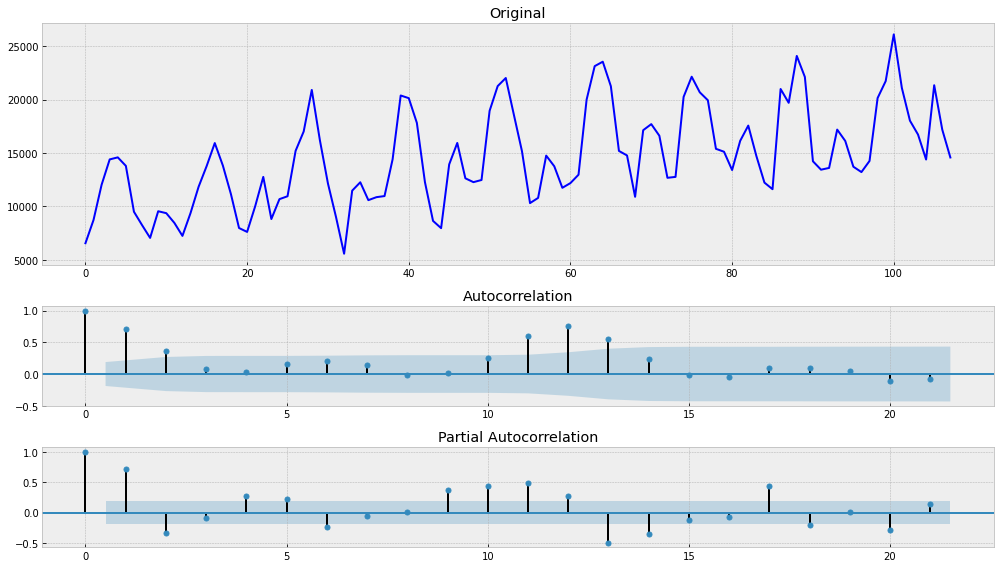

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1], dftest[2]

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    p_val, lag = test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return p_val, lag

df = pd.read_csv('monthly-car-sales-in-quebec-1960.csv').dropna()
df.head()
original_series = df.iloc[:,1]
p_val, lag = tsplot(original_series)

Ряд характеризуется ростом во времени дисперсии и сезонностью.

Применим преобразование Бокса-Кокса, дифференцирование и избавимся от сезонности:

Results of Dickey-Fuller Test:
Test Statistic                 -4.234656
p-value                         0.000575
#Lags Used                     11.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


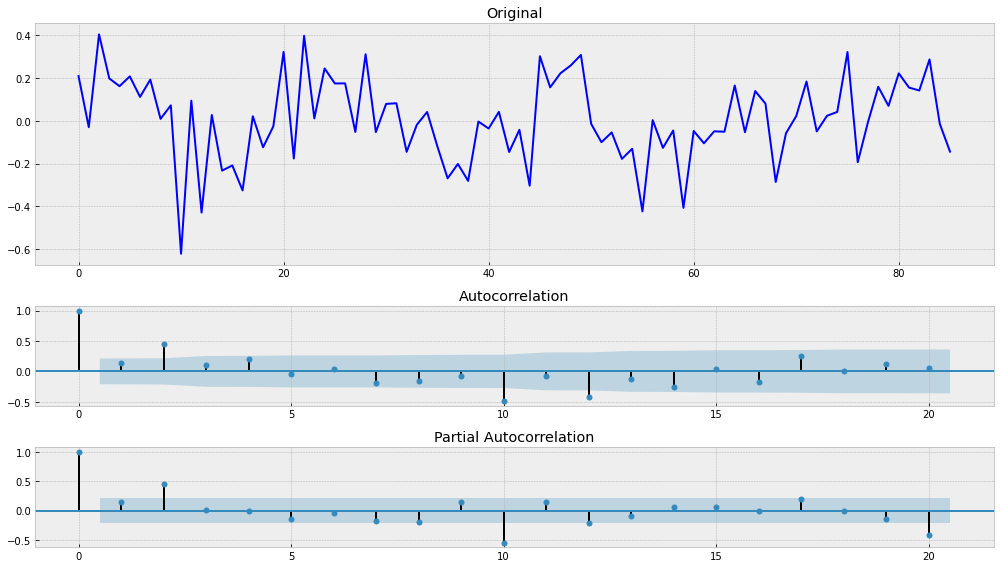

In [5]:
series = boxcox(original_series, 0)
series = series[10:] - series[:-10]
series = series[lag:] - series[:-lag]
p_val, lag = tsplot(series)

Итак, попробуем получить аналогичные ряды с помощью MA.

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

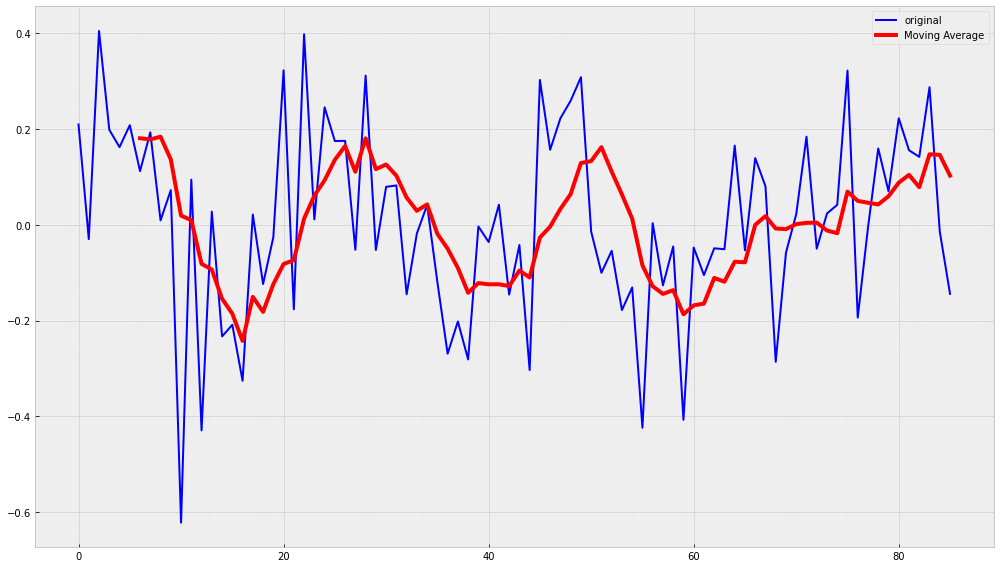

In [7]:
ser = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.tight_layout()
    plt.legend()

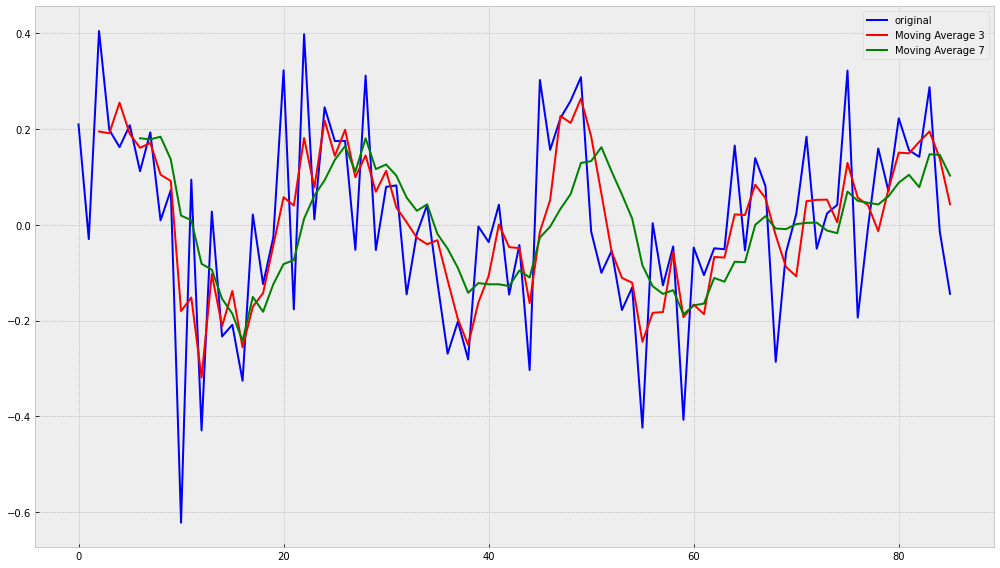

In [8]:
windows = [3,7]
colors = ['red', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.tight_layout()
    plt.legend()

Применим двойное сглаживание, тройное не требуется, т.к. ряд очищен от сезонности.

In [9]:
def double_ema(series, alpha, beta, n_preds=0):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for i in range(1, len(series)+n_preds):
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            last_level, level = level, alpha*value + (1-alpha)*(level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            result.append(level + m*trend)
        else:
            value = series[i]
            last_level, level = level, alpha*value + (1-alpha)*(level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            result.append(level+trend)

    return pd.Series(result)

In [10]:
def plot_dema(series, alpha, beta, ser_to_plot=series, n_preds=0):
    dema = double_ema(series, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.tight_layout()
        plt.legend()

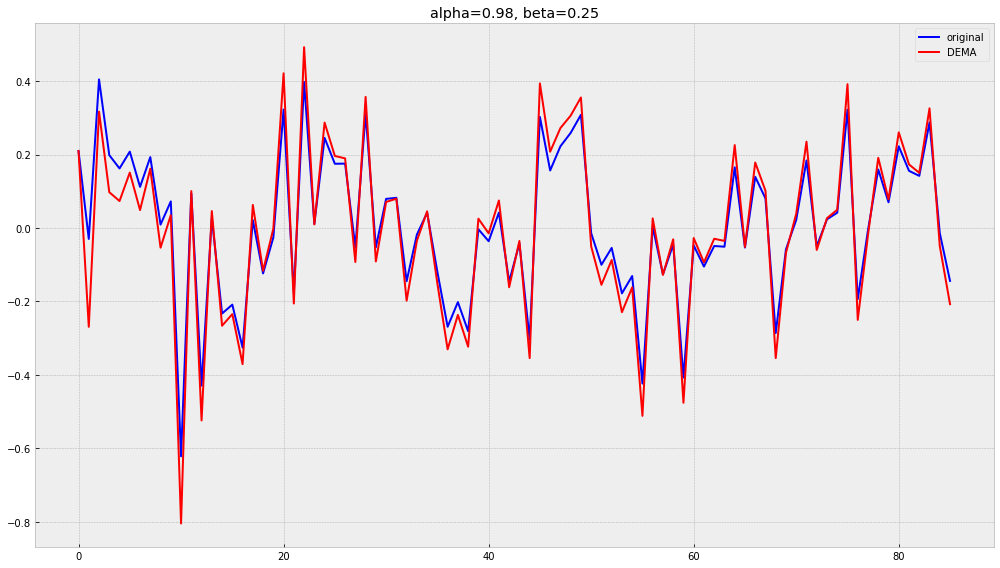

In [11]:
plot_dema(series, 0.98, 0.25)

Попробуем подобрать оптимальные параметры 

In [12]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [13]:
train, test, val = series[:60], series[60:70], series[70:]

In [14]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [15]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [16]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.24573197658292623
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.00971775e-02, -6.38378239e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 15
   status: 0
  success: True
        x: array([1.        , 0.08179289])


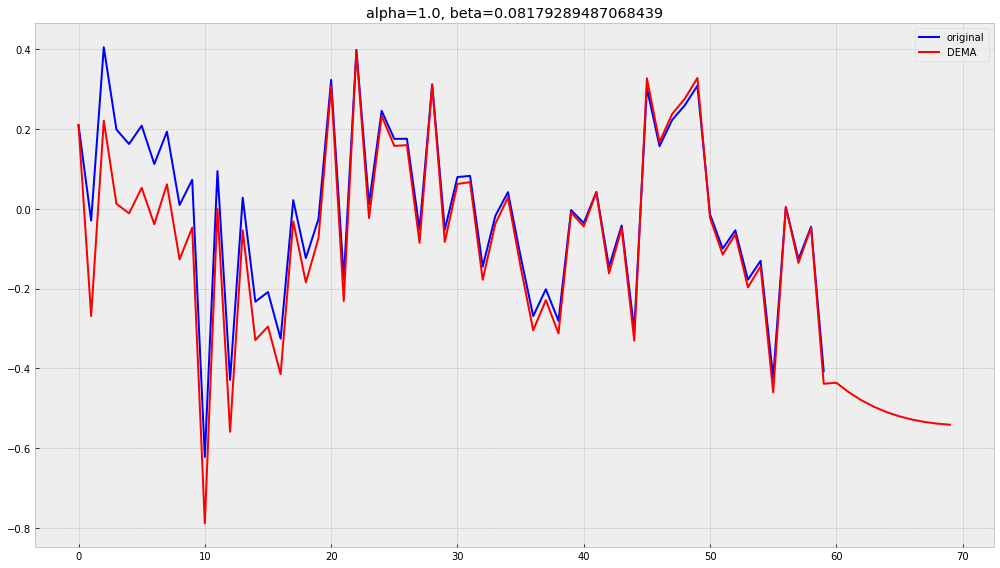

In [17]:
plot_dema(series=train, alpha=alpha_opt, beta=beta_opt, ser_to_plot=series[:70], n_preds=len(test))

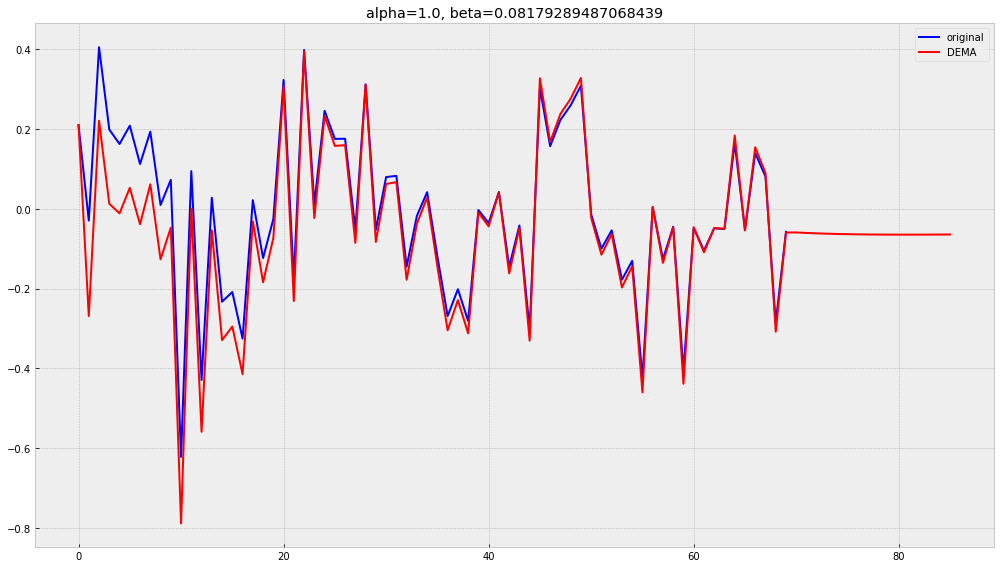

In [18]:
plot_dema(series=series[:70], alpha=alpha_opt, beta=beta_opt, ser_to_plot=series, n_preds=len(val))

### Теперь рассмотрим оригинальный ряд

Ввиду наличия сезонности у оригинального ряда применим тройное сглаживание Хольта-Винтерса

In [19]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [20]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [21]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [22]:
def plot_tema(alpha, beta, gamma, ser=original_series, ser_to_plot=original_series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.tight_layout()
        plt.legend()

In [23]:
series = original_series

In [24]:
train, test, val = series[:60], series[60:70], series[70:]

In [25]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [26]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [27]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1373674.6999430123
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1501.94391608, -5764.04854655,  -344.17025745])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 320
      nit: 35
   status: 0
  success: True
        x: array([0.00139039, 0.98451022, 0.26035557])


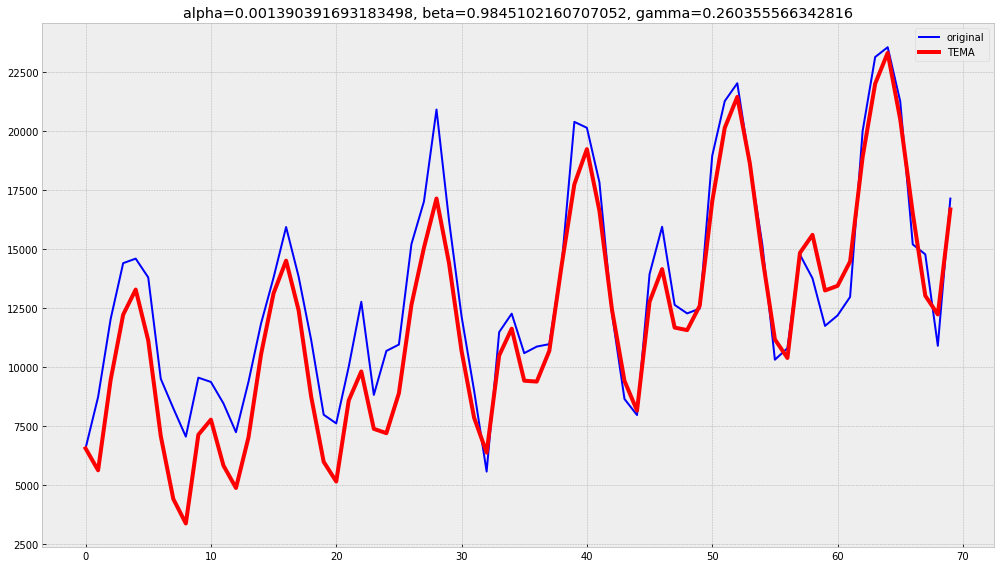

In [28]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

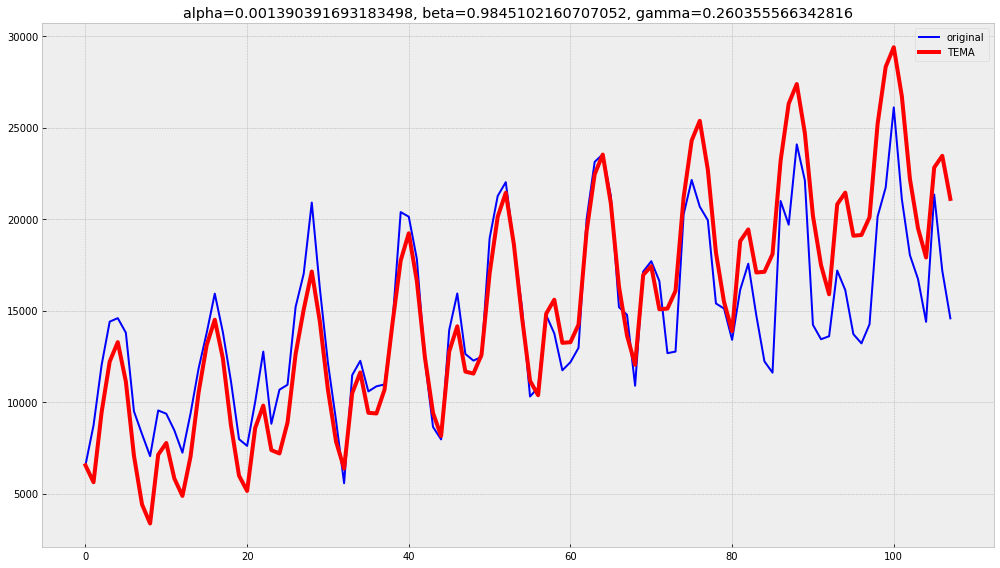

In [29]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

Попадаем в сезонность, тренд, но не попадаем в растущую амплитуду (дисперсию) ряда.

Подбор параметров вручную:

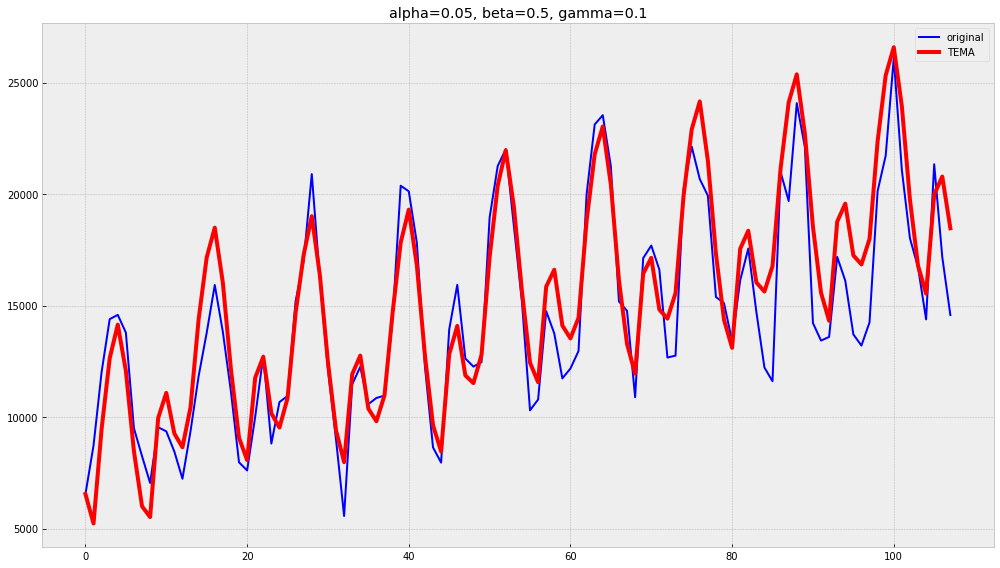

In [35]:
plot_tema(0.05, 0.5, 0.1, ser=series[:70], ser_to_plot=series, n_preds=len(val))